# MuCoST for Human Breast Cancer datasets of 10X Visium

# import MuCoST

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from MuCoST.mucost import training_model
from MuCoST.utils import mclust
from MuCoST.config import set_arg

# hyperparameter setting

In [3]:
opt = set_arg()
arg = opt.parse_args(['--mode_his', 'noh'])
arg.n_domain=20
arg.radius=300
arg.temp=0.05
arg.use_eattr=True
arg.e_attr=0.3
arg.latent_dim=20
arg.cut_corr = True
arg.corr = 0.8
arg

Namespace(seed=2023, latent_dim=20, epoch=1000, lr=0.001, weight_decay=0.0, log_step=10, drop_feat_p=0.2, flow='source_to_target', radius=300, hvg_n=3000, rknn=6, knn=6, n_domain=20, temp=0.05, n_refine=25, mode_his='noh', mode_rknn='rknn', e_attr=0.3, use_eattr=True, corr=0.8, cut_corr=True)

## reading data

In [4]:
input_dir = os.path.join('Data/4-Human_Breast_Cancer')
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
if arg.mode_his == 'his':
    img=cv2.imread(input_dir + "/spatial/image.tif")
    adata.uns['image']=img
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Showing ground truth

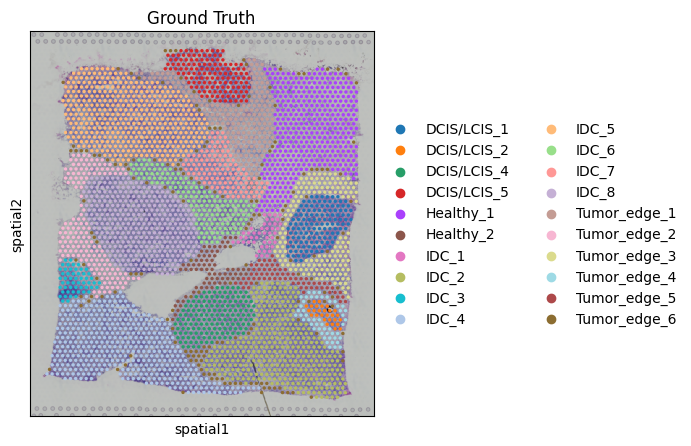

In [5]:
Ann_df = pd.read_csv(os.path.join('Data/Human_BC/', 'metadata.tsv'), sep='\t', header=0, index_col=0)
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

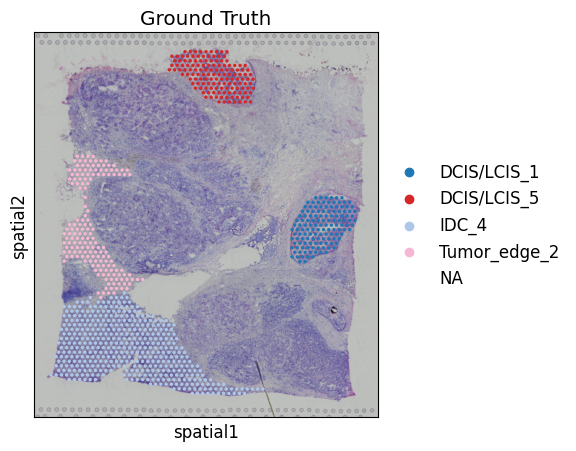

In [80]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['DCIS/LCIS_1','DCIS/LCIS_5','Tumor_edge_2','IDC_4'])

## training model

Average spatial edge: 5.809373354397051
Average feature edge: 5.62769878883623


  0%|          | 0/1000 [00:00<?, ?it/s]

EP[ 100]: loss=0.8819.
EP[ 200]: loss=0.8188.
EP[ 300]: loss=0.7859.
EP[ 400]: loss=0.7759.
EP[ 500]: loss=0.7653.
EP[ 600]: loss=0.7606.
EP[ 700]: loss=0.7518.
EP[ 800]: loss=0.7476.
EP[ 900]: loss=0.7426.
EP[1000]: loss=0.7432.


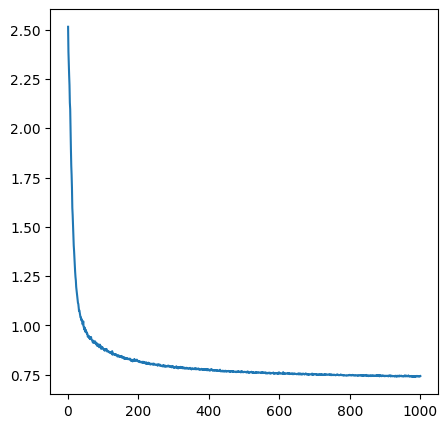

In [7]:
adata = training_model(adata, arg)

## clustering with muclust

In [8]:
adata = mclust(adata, arg, refine=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## computing ARI

In [9]:
adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.5941


In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
silhouette_avg = silhouette_score(adata.obsm['MuCoST'],obs_df['mclust'])
silhouette_avg

0.10476384

In [11]:
ch_score = calinski_harabasz_score(adata.obsm['MuCoST'],obs_df['mclust'])
ch_score

220.1638519346806

In [12]:
db_score = davies_bouldin_score(adata.obsm['MuCoST'],obs_df['mclust'])
db_score

2.2018620718300745

In [13]:
def compute_lisi(adata):
    cluster_labels = adata.obs['mclust']
    unique_clusters = np.unique(cluster_labels)

    lis_values = []
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_abundance = len(cluster_indices)
        lis_values.append(cluster_abundance)

    lis_values = np.array(lis_values)
    lisi = 1 / np.sum((lis_values / np.sum(lis_values))**2)
    return lisi
lisi_value = compute_lisi(adata)
lisi_value

14.130770918723208

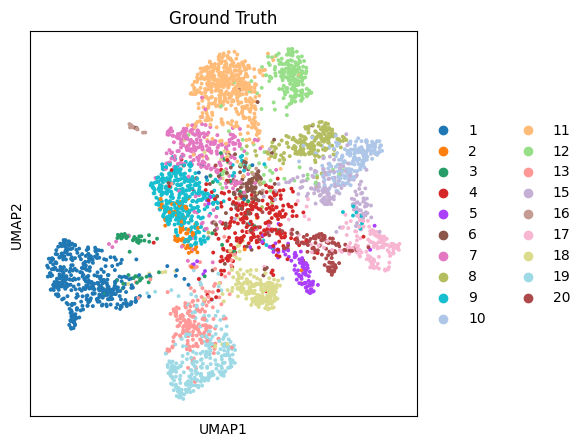

In [14]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=[ "mclust"], title=["Ground Truth"])

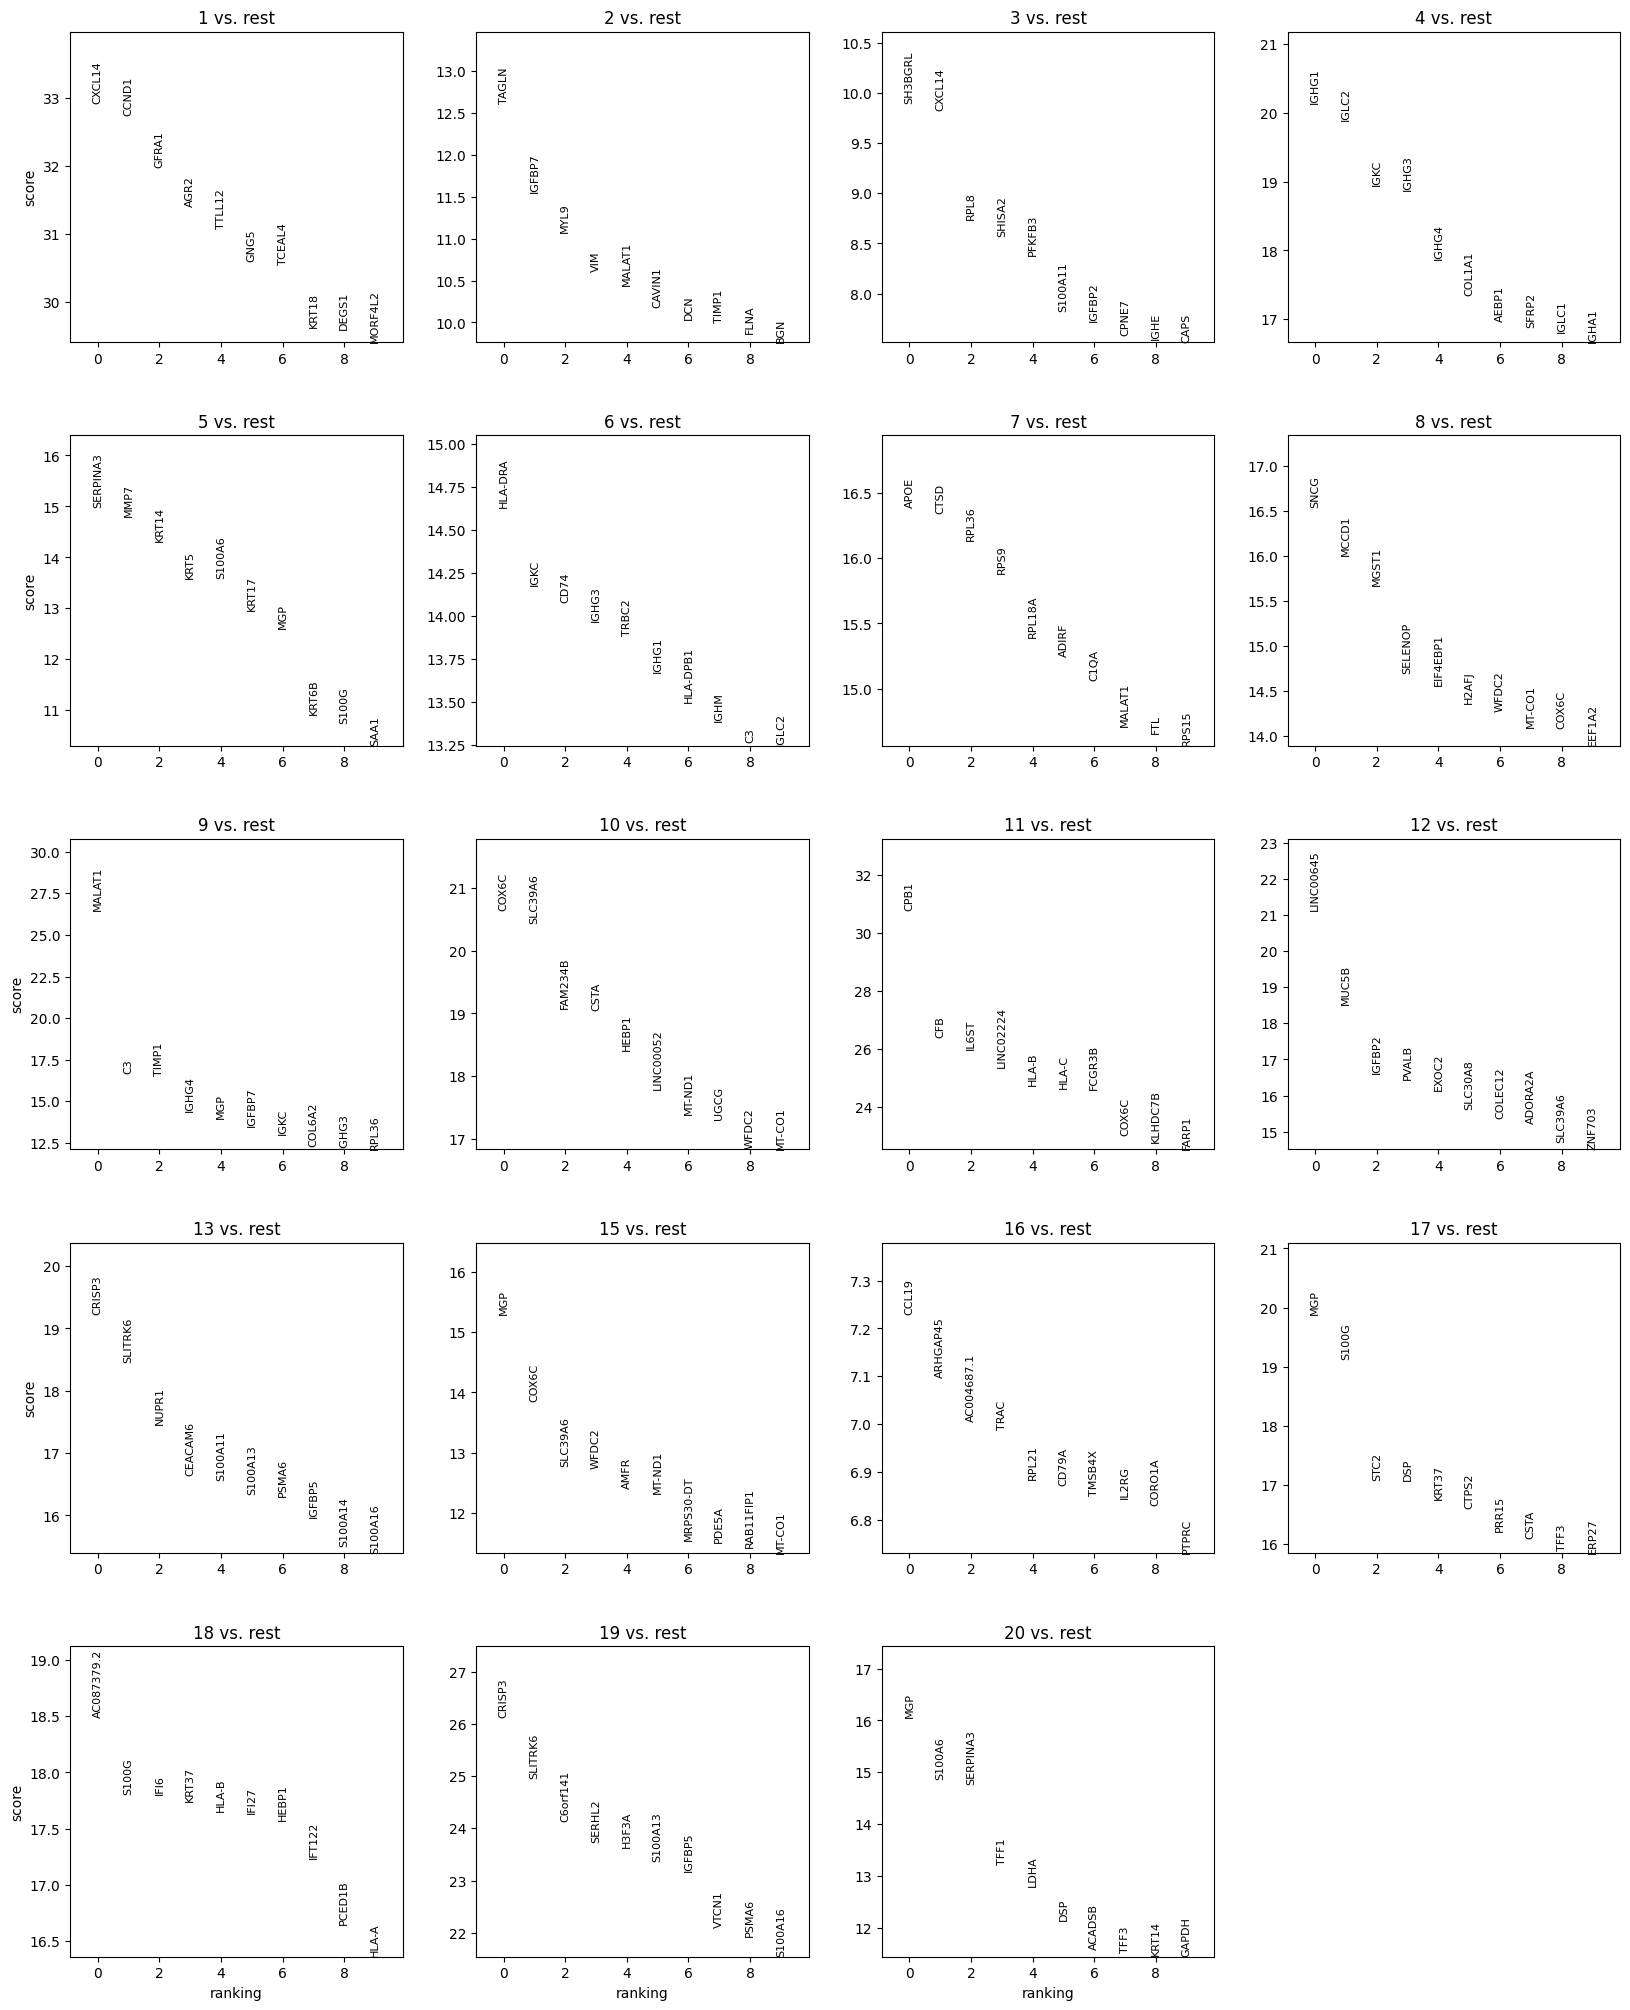

In [15]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.tl.rank_genes_groups(adata, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

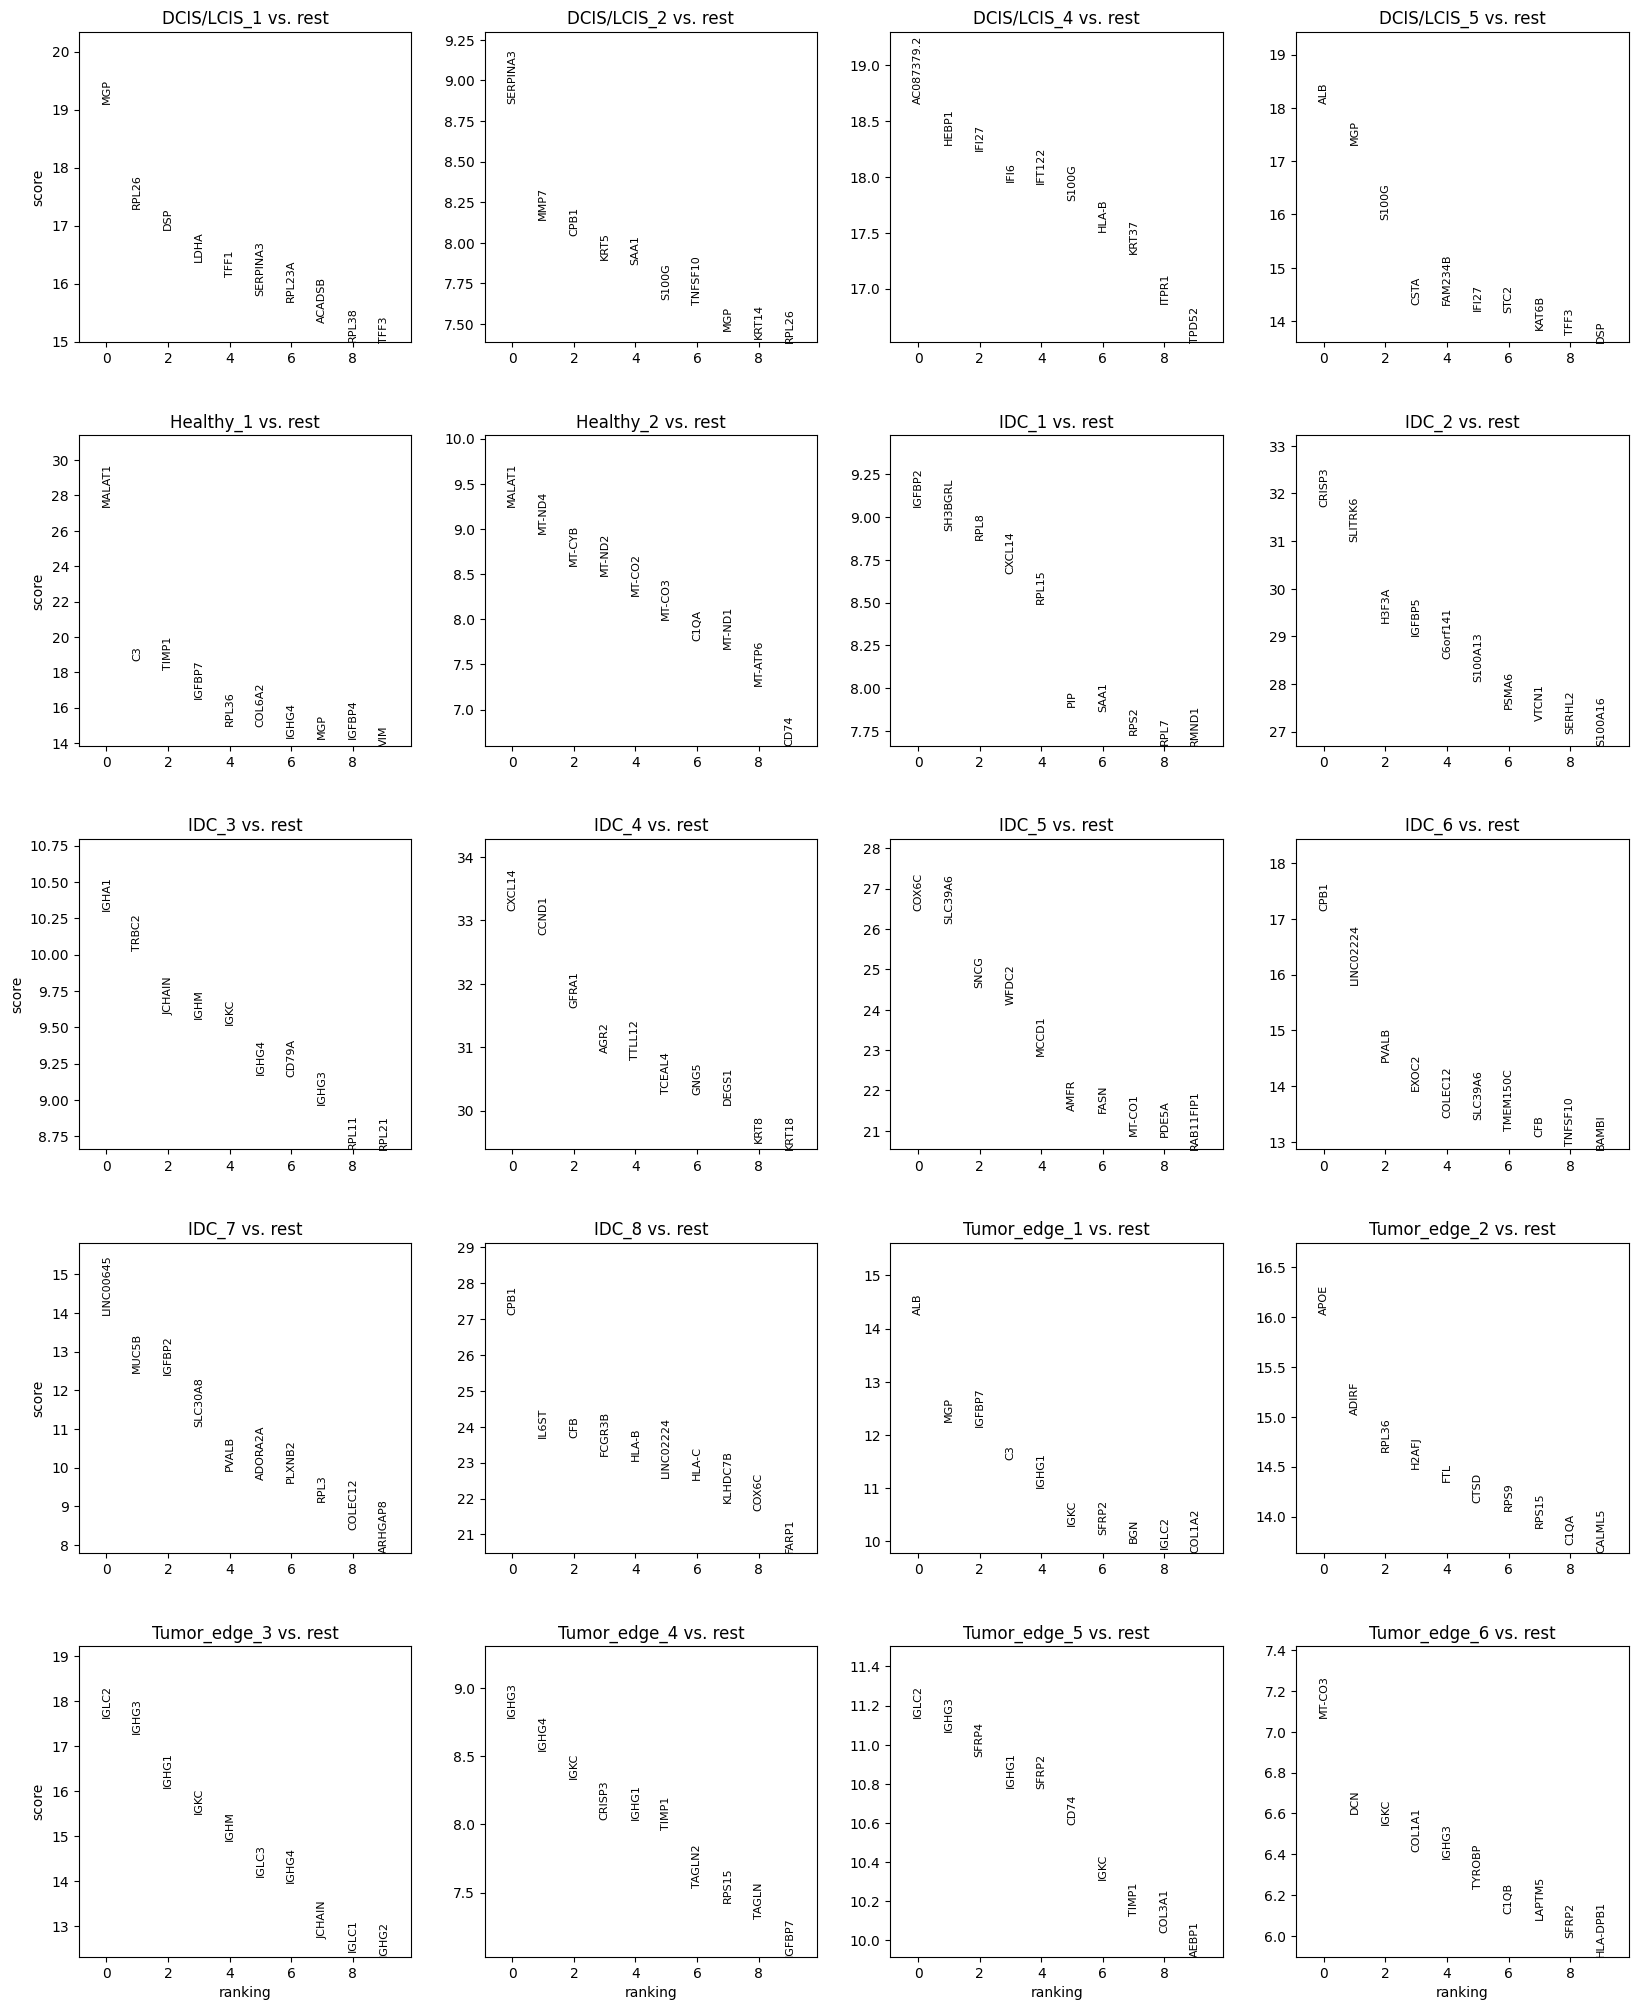

In [16]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.tl.rank_genes_groups(adata, 'Ground Truth', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

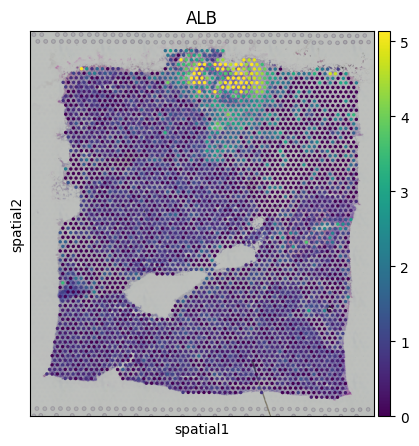

In [17]:
sc.pl.spatial(adata, img_key="hires", color='ALB', show=True, vmax='p99')

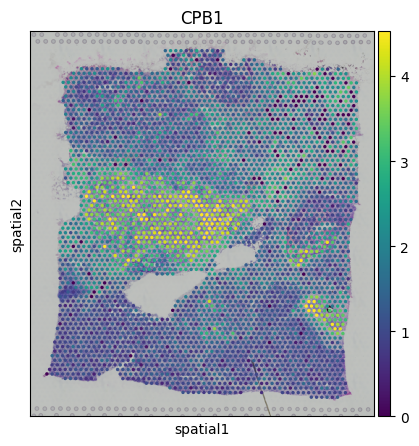

In [18]:
sc.pl.spatial(adata, img_key="hires", color='CPB1', show=True,  vmax='p99')

## spatial architectures

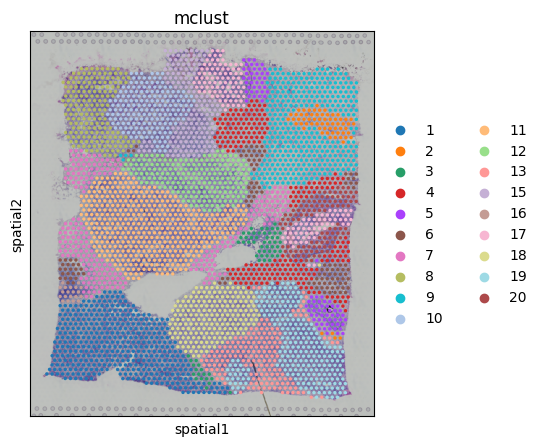

In [19]:
# plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, color=["mclust"], )

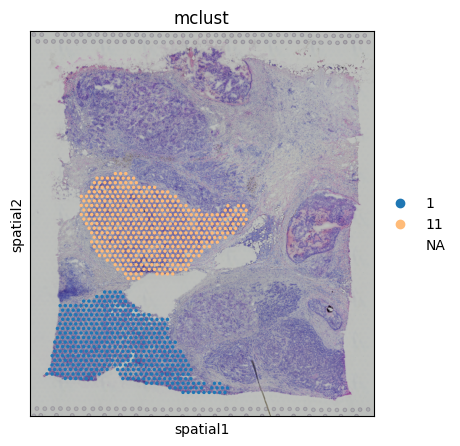

In [20]:
sc.pl.spatial(adata, img_key="hires", color=["mclust"], groups=['1','11'])

AAACAAGTATCTCCCA-1     4
AAACACCAATAACTGC-1     1
AAACAGAGCGACTCCT-1     9
AAACAGGGTCTATATT-1     6
AAACAGTGTTCCTGGG-1     1
                      ..
TTGTTGTGTGTCAAGA-1    12
TTGTTTCACATCCAGG-1     1
TTGTTTCATTAGTCTA-1     1
TTGTTTCCATACAACT-1    11
TTGTTTGTGTAAATTC-1    15
Name: mclust, Length: 3798, dtype: category
Categories (19, object): ['1', '2', '3', '4', ..., '17', '18', '19', '20']


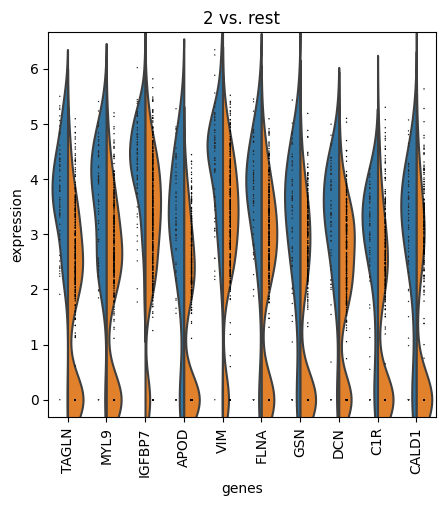

In [22]:
group = adata[(adata.obs['mclust']=='2') | (adata.obs['mclust']=='9')]
print(adata.obs['mclust'])

sc.tl.rank_genes_groups(group, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups_violin(group, groups=['2'], n_genes=10, jitter=False)

In [23]:
adata_rec = adata[:, adata.var['highly_variable']].copy()
adata_rec.layers['rec'] = adata.obsm['rec']
adata_rec.layers['raw'] = adata.obsm['raw_feature']

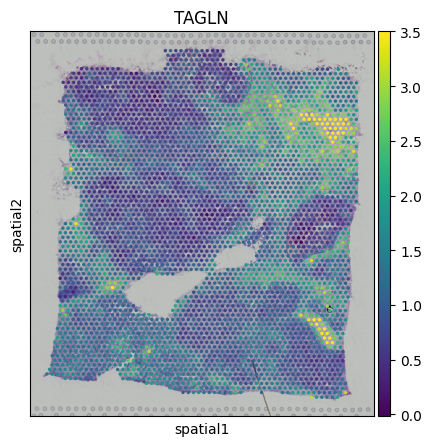

In [24]:
sc.pl.spatial(adata_rec, img_key="hires", color='TAGLN', show=True, vmax='3.5',layer='rec')

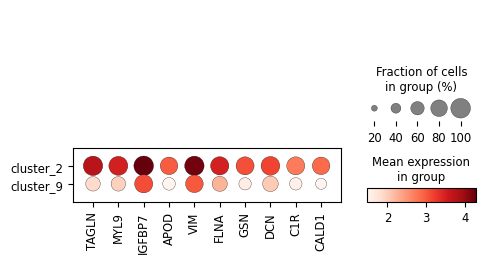

In [25]:
mark_genes1 = ['TAGLN','MYL9','IGFBP7','APOD','VIM','FLNA','GSN','DCN','C1R','CALD1']
mark_genes2 = ['COX6C','TFF3','KRT8','PBX1','CALML5','KRT18','IGFBP5','KRT19','MORF4L2','LGALS3BP']
selected_clusters = ['2','9']
# 筛选数据
adata_selected = adata[adata.obs['mclust'].isin(selected_clusters)]

# # 创建基因表达矩阵
gene_expression = pd.DataFrame(adata_selected.X.todense(), index=adata_selected.obs_names, columns=adata_selected.var_names)

# # 创建新的AnnData对象
adata_filtered = sc.AnnData(X=gene_expression, obs=adata_selected.obs)

cluster_anno={'2':'cluster_2','9':'cluster_9'}
adata_filtered.obs['domain_type']=adata_filtered.obs['mclust'].astype('str').map(cluster_anno)

sc.pl.dotplot(adata_filtered , mark_genes1, groupby='domain_type',dendrogram=False)

In [26]:
adata.obs.head()

in_tissue  array_row  array_col  Ground Truth mclust
AAACAAGTATCTCCCA-1          1         50        102  Tumor_edge_5      4
AAACACCAATAACTGC-1          1         59         19         IDC_4      1
AAACAGAGCGACTCCT-1          1         14         94     Healthy_1      9
AAACAGGGTCTATATT-1          1         47         13         IDC_3      6
AAACAGTGTTCCTGGG-1          1         73         43         IDC_4      1

In [27]:
adata.obs.groupby('mclust')

In [28]:
c1 = '2'
c2 = '9'

In [29]:
cluster_mask = (adata.obs['mclust'] == c1) | (adata.obs['mclust'] == c2)

In [30]:
group1 = adata[adata.obs['mclust'] == c1]
group2 = adata[adata.obs['mclust'] == c2]

In [31]:
adata_g = adata[cluster_mask]
cluster_anno={c1:'inner',c2:'outer'}
adata_g.obs['domain_type']=adata_g.obs['mclust'].astype('str').map(cluster_anno)

In [33]:
adata_rec_g = adata_g[:, adata_g.var['highly_variable']].copy()
adata_rec_g.layers['rec'] = adata_g.obsm['rec']
adata_rec_g.layers['raw'] = adata_g.obsm['raw_feature']

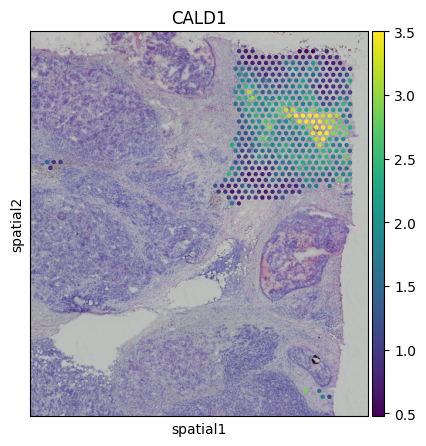

In [34]:
sc.pl.spatial(adata_rec_g, img_key="hires", color='CALD1', show=True, vmax='3.5',layer='rec')

In [35]:
sum(adata_g.var['highly_variable'])

3000

In [36]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
silhouette_avg = silhouette_score(adata_g.obsm['MuCoST'], adata_g.obs['mclust'])
print("轮廓系数:", silhouette_avg)
davies_bouldin_score = davies_bouldin_score(adata_g[:, adata_g.var['highly_variable']].X.toarray(), adata_g.obs['mclust'])
print("Davies-Bouldin指数:", davies_bouldin_score)

轮廓系数: 0.1651968
Davies-Bouldin指数: 8.147622123798937


In [37]:
from sklearn import metrics
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

# 假设有聚类结果labels和样本特征矩阵X

# 计算类内平均距离
def average_intra_cluster_distance(labels, X):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    intra_distances = np.zeros(n_clusters)
    for i, label in enumerate(unique_labels):
        cluster_samples = X[labels == label]
        if len(cluster_samples) > 1:
            intra_distances[i] = metrics.pairwise_distances(cluster_samples).mean()
    return intra_distances.mean()

# 计算方差或标准差
def intra_cluster_variance(labels, X):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    variances = np.zeros(n_clusters)
    for i, label in enumerate(unique_labels):
        cluster_samples = X[labels == label]
        if len(cluster_samples) > 1:
            variances[i] = np.var(cluster_samples)
    return variances.mean()

# 计算簇内相似度（余弦相似度）
def intra_cluster_similarity(labels, X):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    similarities = np.zeros(n_clusters)
    for i, label in enumerate(unique_labels):
        cluster_samples = X[labels == label]
        if len(cluster_samples) > 1:
            similarities[i] = metrics.pairwise.cosine_similarity(cluster_samples).mean()
    return similarities.mean()

# 计算类内密度（基于核密度估计）
def intra_cluster_density(labels, X):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    densities = np.zeros(n_clusters)
    for i, label in enumerate(unique_labels):
        cluster_samples = X[labels == label]
        if len(cluster_samples) > 1:
            kde = LocalOutlierFactor(n_neighbors=5).fit(cluster_samples)
            densities[i] = np.mean(kde.negative_outlier_factor_)
    return densities.mean()

# 使用示例
labels = adata_g.obs['mclust']
X = adata_g[:, adata_g.var['highly_variable']].X.toarray()
X=X=adata_g.obsm['MuCoST']
avg_distance = average_intra_cluster_distance(labels, X)
variance = intra_cluster_variance(labels, X)
similarity = intra_cluster_similarity(labels, X)
density = intra_cluster_density(labels, X)

print("Average Intra-Cluster Distance:", avg_distance)
print("Intra-Cluster Variance:", variance)
print("Intra-Cluster Similarity:", similarity)
print("Intra-Cluster Density:", density)

Average Intra-Cluster Distance: 12.722278118133545
Intra-Cluster Variance: 22.016528129577637
Intra-Cluster Similarity: 0.8624017536640167
Intra-Cluster Density: -1.0736141800880432


In [39]:
gene_sets_select = ['GO_Biological_Process_2023']

In [40]:

import gseapy as gp
res = gp.gsea(data=adata_g.to_df().T, # row -> genes, column-> samples
        gene_sets=gene_sets_select,
        cls=adata_g.obs.domain_type,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)

In [41]:
res.res2d.head(10)

Name                                               Term        ES  \
0  gsea  GO_Biological_Process_2023__Collagen Fibril Or... -0.685795   
1  gsea  GO_Biological_Process_2023__Peptide Biosynthet... -0.630928   
2  gsea  GO_Biological_Process_2023__Cytoplasmic Transl... -0.733016   
3  gsea  GO_Biological_Process_2023__Macromolecule Bios... -0.591261   
4  gsea  GO_Biological_Process_2023__Vasculature Develo... -0.783903   
5  gsea  GO_Biological_Process_2023__Vasculogenesis (GO...  -0.66278   
6  gsea  GO_Biological_Process_2023__Blood Vessel Morph... -0.595212   
7  gsea  GO_Biological_Process_2023__Artery Morphogenes... -0.671464   
8  gsea  GO_Biological_Process_2023__Circulatory System... -0.505626   
9  gsea  GO_Biological_Process_2023__Regulation Of Endo... -0.544573   

        NES NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
0 -2.602929       0.0       0.0        0.0   16/40   7.35%   
1 -2.584035       0.0       0.0        0.0  61/140  12.96%   
2 -2.575762       0.0       0.0        0.0   49/91   7.73%   
3 -2.551593       0.0       0.0        0.0  66/168  12.96%   
4 -2.525297       0.0       0.0        0.0   11/16  16.06%   
5 -2.520229       0.0       0.0        0.0   10/30   6.55%   
6 -2.512049       0.0       0.0        0.0   20/48  15.56%   
7 -2.497061       0.0  0.000277      0.001   13/27  11.99%   
8 -2.480071       0.0  0.000492      0.002  46/117  18.00%   
9  -2.47281       0.0  0.000664      0.003   38/85  22.30%   

                                          Lead_genes  
0  COL1A2;COL14A1;LUM;COL18A1;COL5A1;COL3A1;COL1A...  
1  RPL21;RPS8;RPS24;FAU;RPL34;RPS7;RPS3A;RPS28;RP...  
2  RPL21;RPS8;RPS24;FAU;RPL34;RPS7;RPS3A;RPS28;RP...  
3  RPL21;RPS8;RPS24;FAU;RPL34;RPS7;EEF2;RPS3A;RPS...  
4  PDGFRB;SOX18;CDH5;FOXF1;APLNR;PDGFRA;BMPR2;TCF...  
5  CAV1;ENG;PDGFRB;SOX18;EGFL7;RAMP2;TGFBR2;APLNR...  
6  CAV1;ENG;SOX18;EGFL7;GJA5;RAMP2;PROX1;ID1;TGFB...  
7  ENG;LRP1;PDGFRB;GJA5;JAG1;TGFBR2;BMPR1A;FOXF1;...  
8  SOX18;GJA5;RAMP2;PCSK5;TGFBR2;PDLIM3;COL3A1;CD...  
9  CAV1;EGFL7;THBS1;PROX1;SULF1;PGF;TIE1;NR4A1;AT...

In [42]:
res.ranking.shape

(18277,)

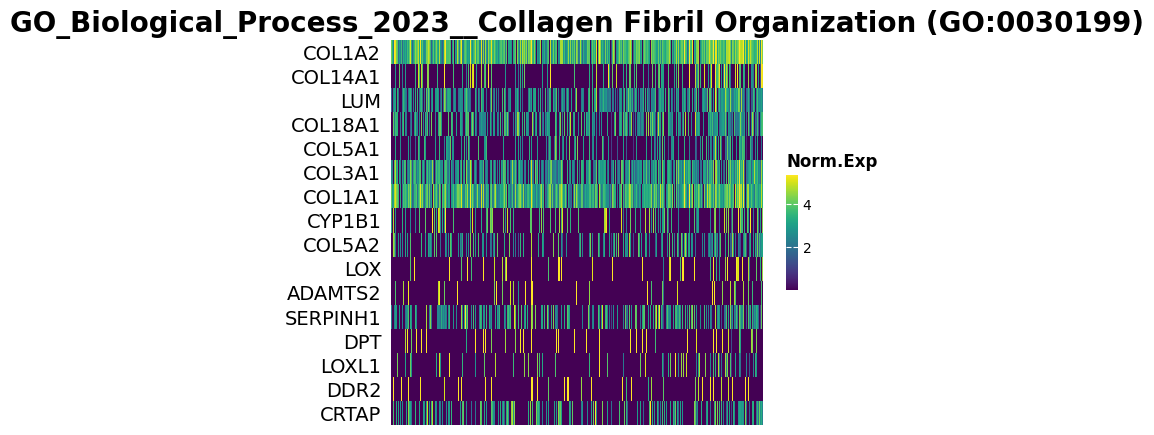

In [43]:
i = 0
genes = res.res2d.Lead_genes.iloc[i].split(";")
ax = gp.heatmap(df = res.heatmat.loc[genes],
           z_score=None,
           title=res.res2d.Term.iloc[i],
           figsize=(6,5),
           cmap=plt.cm.viridis,
           xticklabels=False)

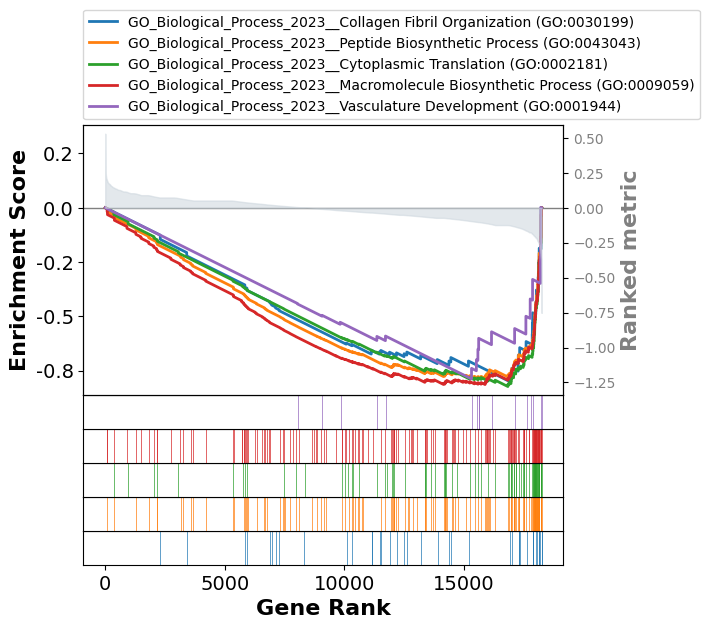

In [44]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:5])

In [45]:
adata_g.X.max() 

10.0

In [46]:
# find degs
sc.tl.rank_genes_groups(adata_g,
                        groupby='domain_type',
                        use_raw=False,

                        method='wilcoxon',
                        groups=["inner"],
                        reference='outer')

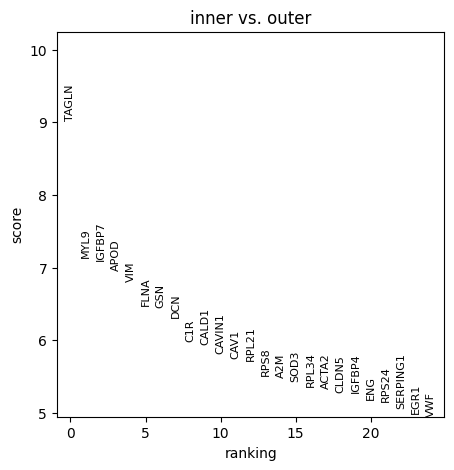

In [47]:
sc.pl.rank_genes_groups(adata_g, n_genes=25, sharey=False)

In [48]:
result = adata_g.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [50]:
degs_sig = degs[degs.inner_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.inner_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.inner_logfoldchanges < 0]

In [54]:
enr_up = gp.enrichr(degs_up.inner_names,
                    gene_sets=gene_sets_select,
                    outdir=None)

In [56]:
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

In [57]:
enr_up.res2d.Term

0                        Cytoplasmic Translation
1             Macromolecule Biosynthetic Process
2                                 Vasculogenesis
3                   Peptide Biosynthetic Process
4                                    Translation
                         ...                    
926    Regulation Of DNA-templated Transcription
927                                  Proteolysis
928                 Protein Modification Process
929                       Organelle Organization
930                              Phosphorylation
Name: Term, Length: 931, dtype: object

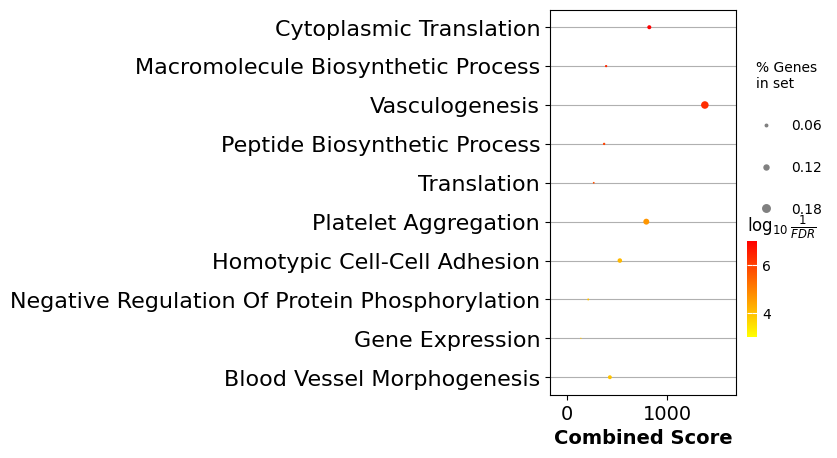

In [58]:
# dotplot
gp.dotplot(enr_up.res2d, figsize=(3,5), title="", cmap = plt.cm.autumn_r)
plt.show()

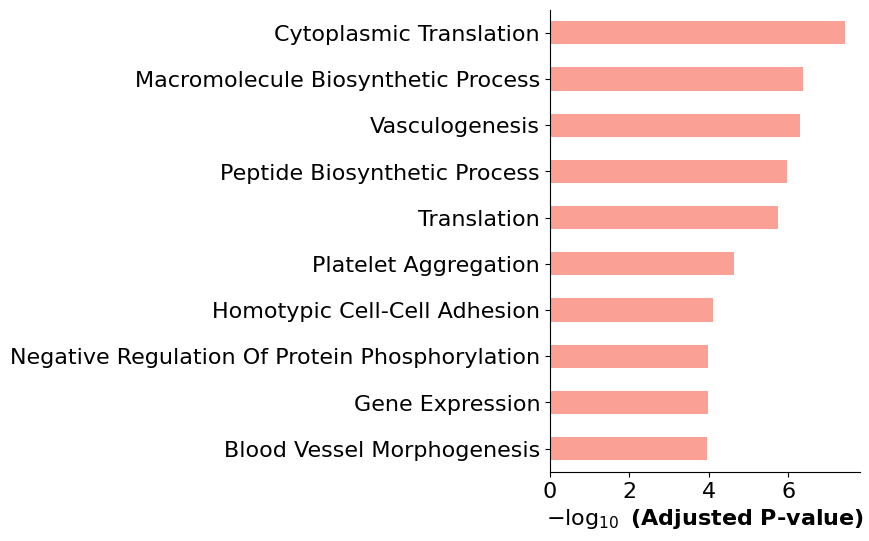

In [59]:
ax = gp.barplot(enr_up.res2d)

In [61]:
enr_dw = gp.enrichr(degs_dw.inner_names,
                    gene_sets=gene_sets_select,
                    outdir=None)

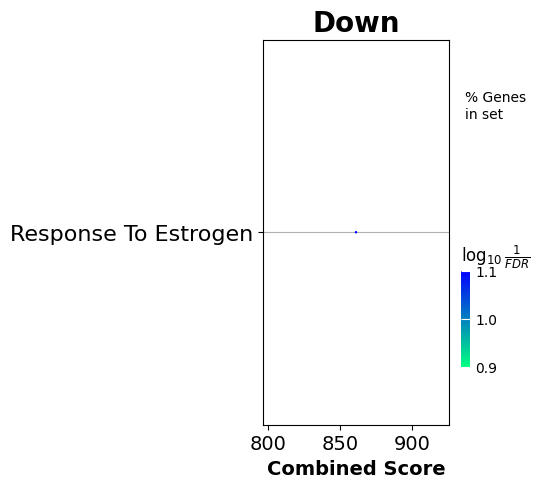

In [63]:
enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
gp.dotplot(enr_dw.res2d,
           figsize=(3,5),
           title="Down",
           cmap = plt.cm.winter_r,
           size=5)
plt.show()

In [64]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(), enr_dw.res2d.head()])

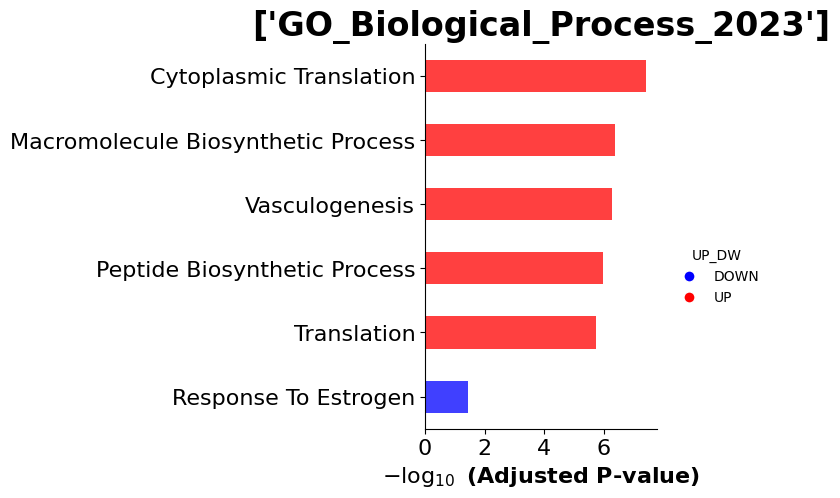

In [65]:
ax = gp.barplot(enr_res, figsize=(3,5),
                group ='UP_DW',
                title =gene_sets_select,
                color = ['b','r'])

AAACAAGTATCTCCCA-1     4
AAACACCAATAACTGC-1     1
AAACAGAGCGACTCCT-1     9
AAACAGGGTCTATATT-1     6
AAACAGTGTTCCTGGG-1     1
                      ..
TTGTTGTGTGTCAAGA-1    12
TTGTTTCACATCCAGG-1     1
TTGTTTCATTAGTCTA-1     1
TTGTTTCCATACAACT-1    11
TTGTTTGTGTAAATTC-1    15
Name: mclust, Length: 3798, dtype: category
Categories (19, object): ['1', '2', '3', '4', ..., '17', '18', '19', '20']


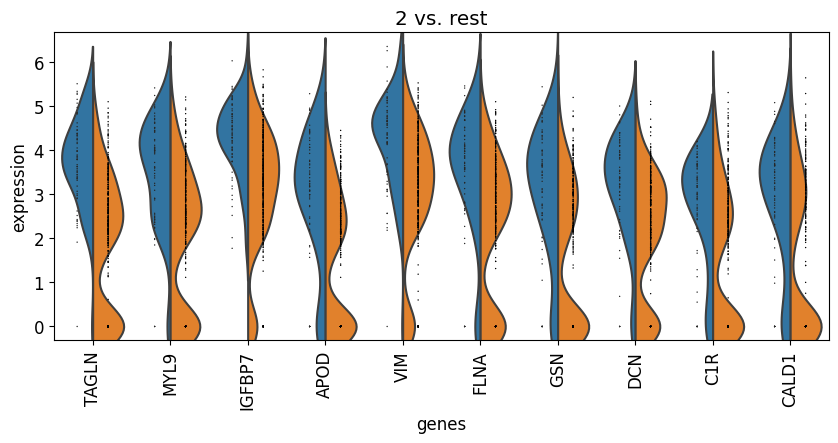

In [66]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams['font.size'] = 12
import warnings
warnings.filterwarnings('ignore')
# group = adata[(adata.obs['mclust']==9) |  (adata.obs['mclust']==4)]
group = adata[(adata.obs['mclust']=='2') | (adata.obs['mclust']=='9')]
print(adata.obs['mclust'])
sc.tl.rank_genes_groups(group, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups_violin(group, groups=['2'], n_genes=10, jitter=False)

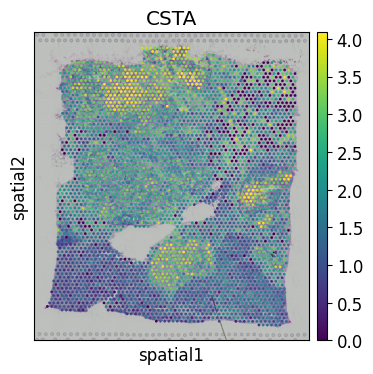

In [67]:
sc.pl.spatial(adata, img_key="hires", color='CSTA', show=True, vmax='p99')

In [68]:
import anndata as ad
import squidpy as sq

  0%|          | 0/1 [00:00<?, ?/s]

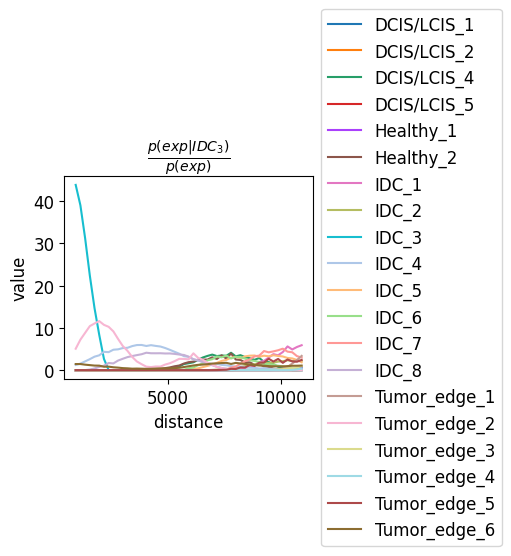

In [69]:
sq.gr.co_occurrence(adata, cluster_key="Ground Truth")
sq.pl.co_occurrence(
    adata,
    cluster_key="Ground Truth",
    clusters="IDC_3",
)

  0%|          | 0/1000 [00:00<?, ?/s]

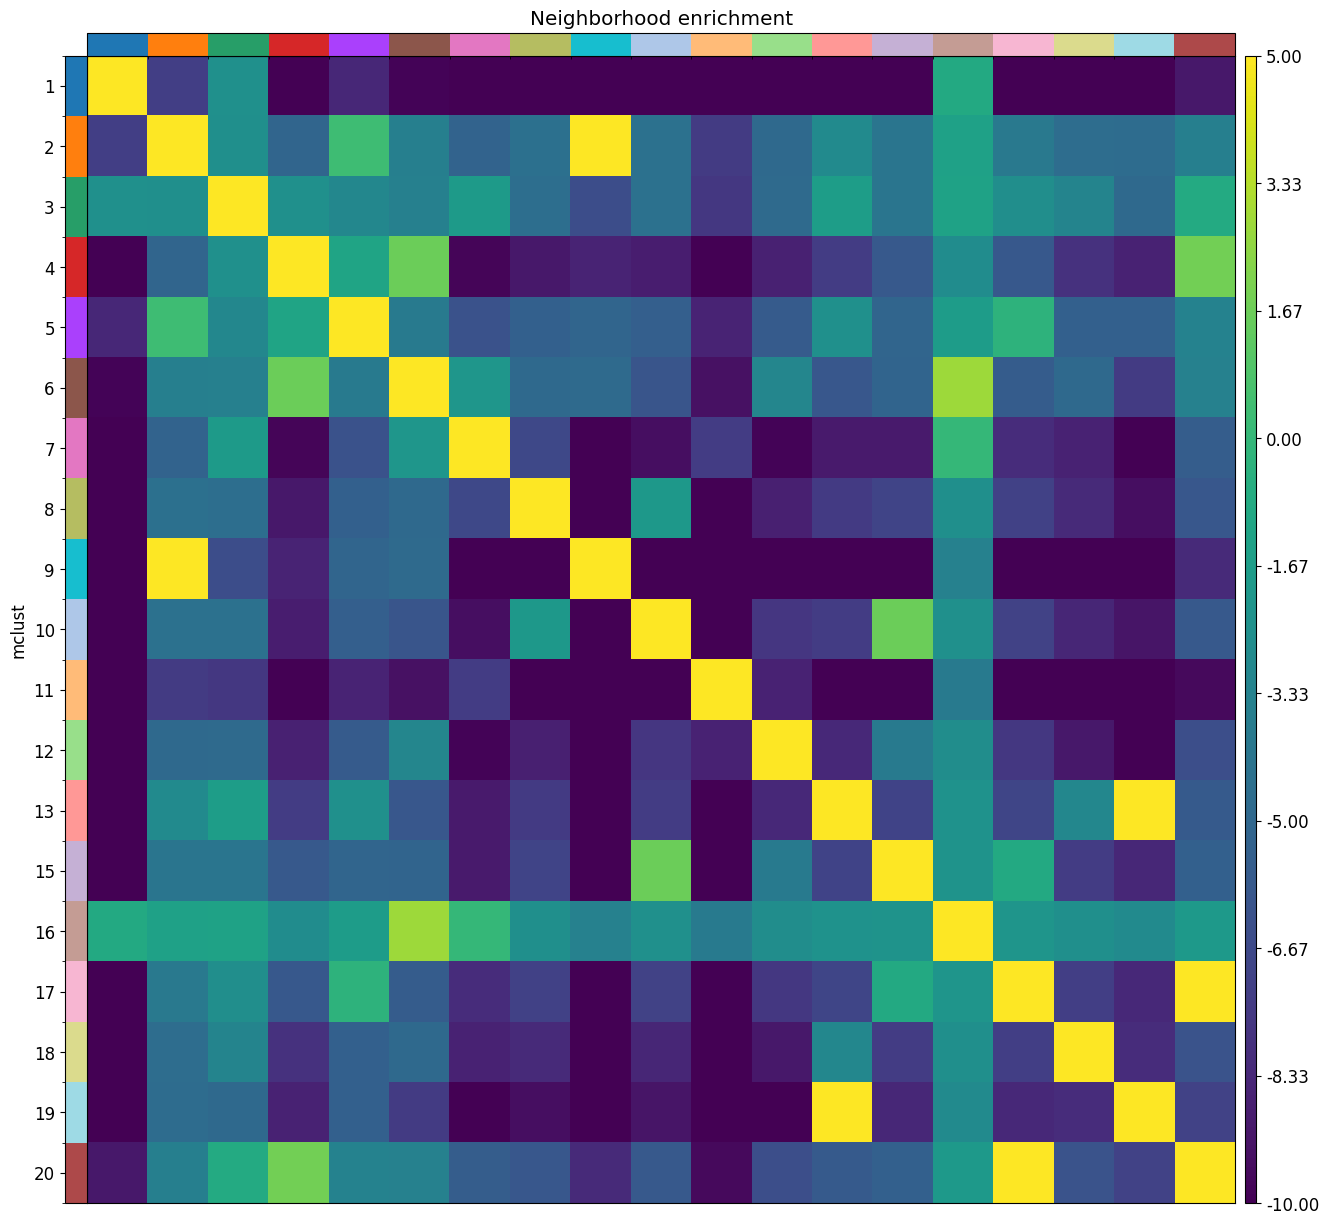

In [70]:
import seaborn as sns
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="mclust")
sq.pl.nhood_enrichment(adata, cluster_key="mclust", vmax=5, vmin=-10)
plt.rcParams['font.size'] = 32

  0%|          | 0/1 [00:00<?, ?/s]

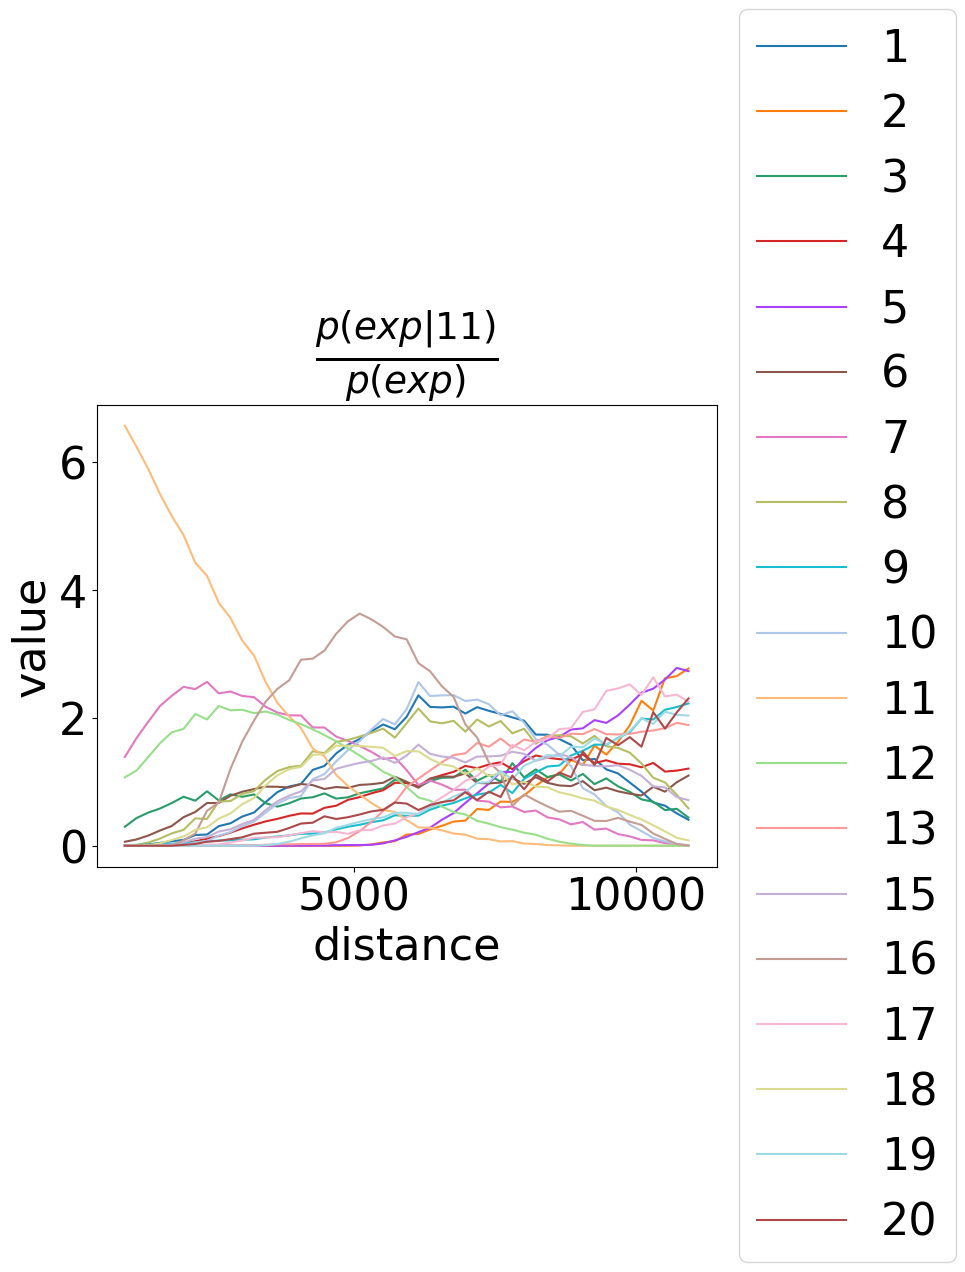

In [71]:
sq.gr.co_occurrence(adata, cluster_key="mclust")
sq.pl.co_occurrence(
    adata,
    cluster_key="mclust",
    clusters="11",
    figsize=(8, 6),
)

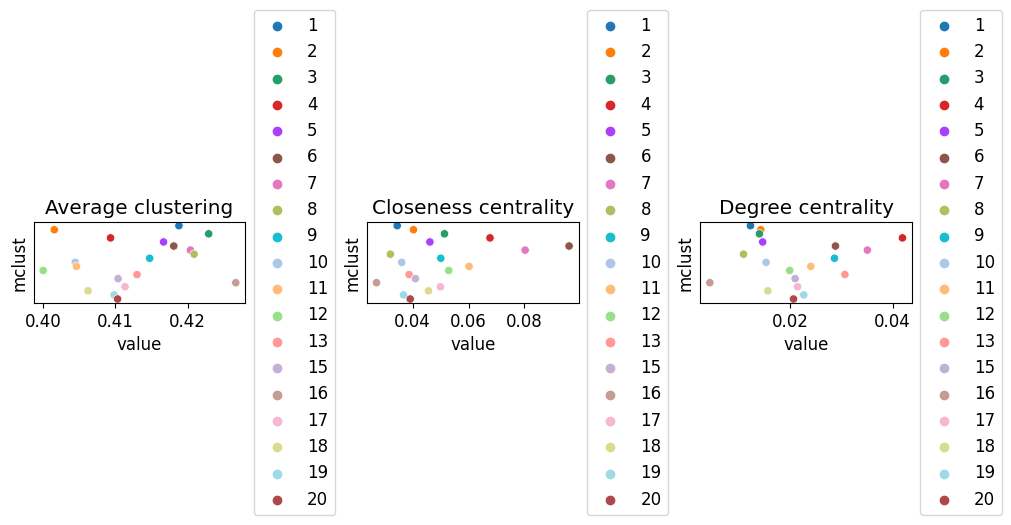

In [72]:
plt.rcParams['font.size'] = 12
sq.gr.centrality_scores(adata, cluster_key='mclust')
sq.pl.centrality_scores(adata, cluster_key='mclust')

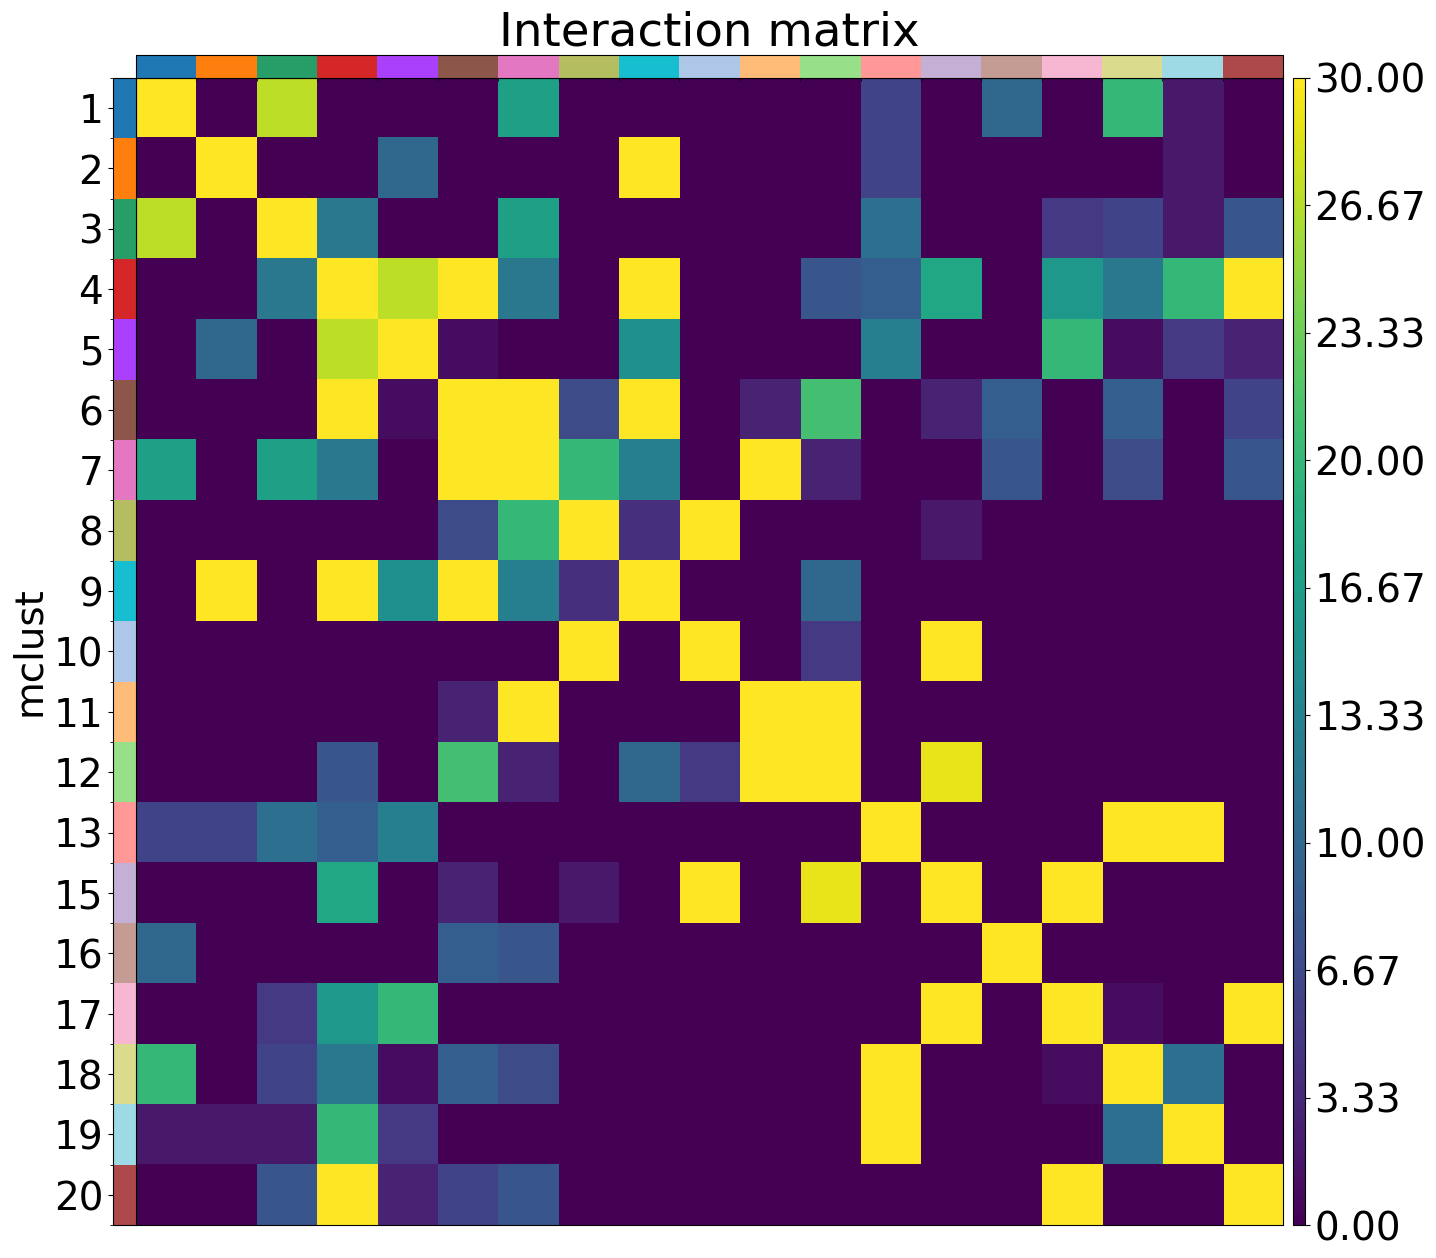

In [73]:
import seaborn as sns
plt.rcParams['font.size'] = 28
sq.gr.interaction_matrix(adata, 'mclust')
sq.pl.interaction_matrix(adata, 'mclust', vmin=0, vmax=30)
plt.rcParams['font.size'] = 12

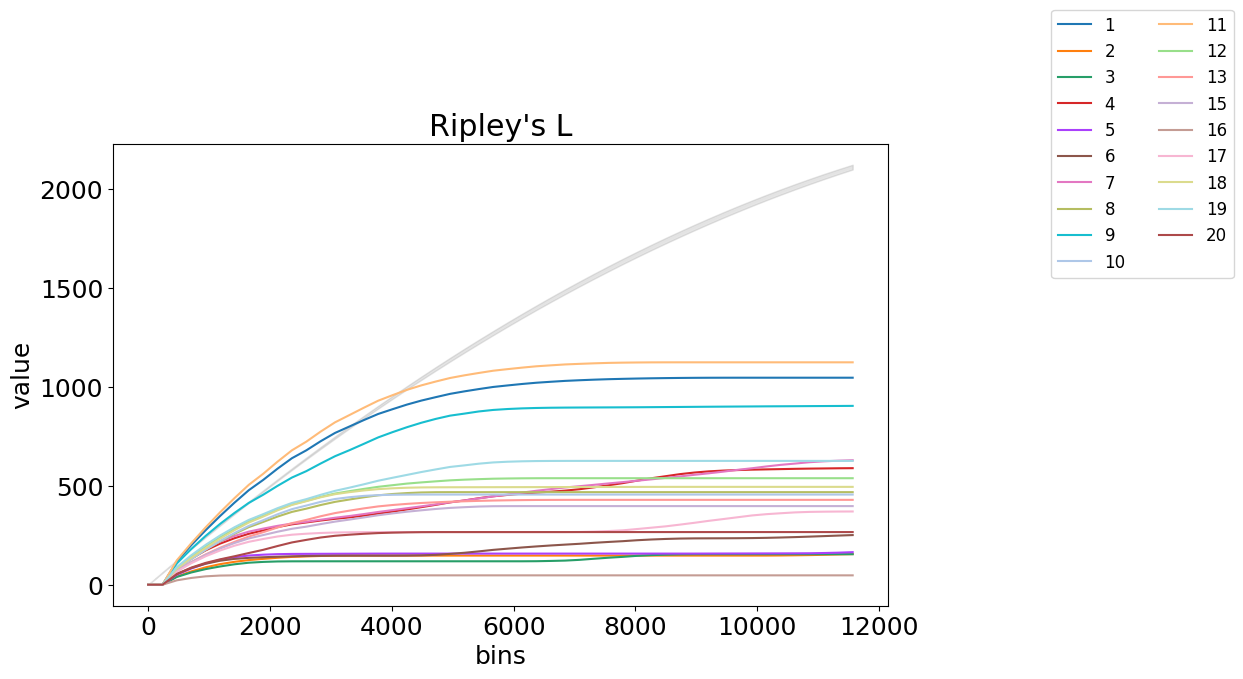

In [74]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['font.size'] = 18
sq.gr.ripley(adata, 'mclust',mode='L')
sq.pl.ripley(adata, 'mclust',mode='L')
plt.rcParams['font.size'] = 12
plt.legend(loc='center left', bbox_to_anchor=(1.2, 1), ncol=2)

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

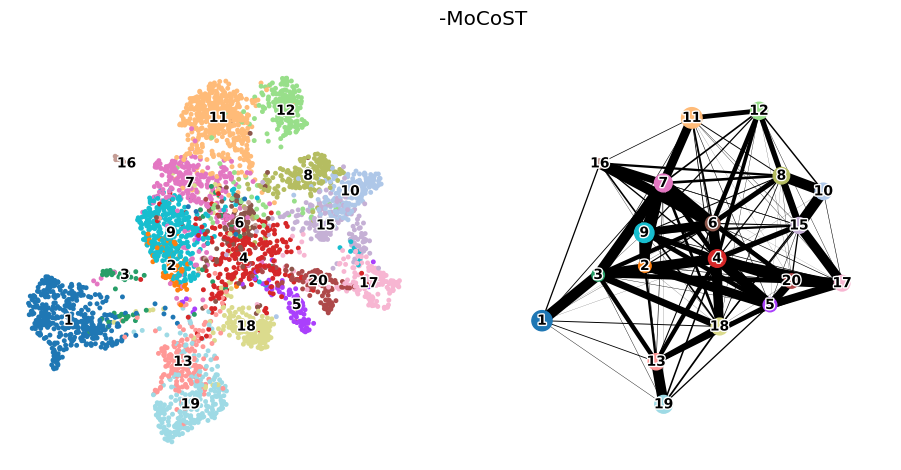

In [75]:
adata = adata[adata.obs['mclust'].notna(),:]
sc.tl.paga(adata,groups='mclust')
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.paga_compare(adata, legend_fontsize=10, frameon=False, size=50,
                   title='-MoCoST', legend_fontoutline=2, show=False)